<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/02_neural_network_cancer_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install scikeras

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn import metrics

from keras import utils as utils_keras

from keras.models import Sequential
from keras.layers import Dense


from scikeras.wrappers import KerasClassifier

import warnings

**Config**
---


In [73]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.simplefilter("ignore")
title_data = 'Supervivencia de Cancer'
paleta = sns.color_palette("tab10").as_hex()

# **Objetivos**
---
- Predecir pacientes con más posibilidades de morir.
- Entender y codificar:
  - cross validation
  - Wrapper
  - Optimización de hiperparametros

# **Dicionario de datos**
---
Conjunto de datos de supervivencia de Haberman

- `Age`: Edad del paciente en el momento de la operación
- `Year`: Año de operación del paciente
- `Nodes`: Número de ganglios axilares positivos detectados
- `status`: Estado de supervivencia
-- 1  paciente sobrevivió 5 años o más
-- 2  paciente murió dentro de los 5 años


# **Data**
---



In [74]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv'
data = pd.read_csv(
    url,
    header=None,
    names=['age', 'year', 'node', 'status'])
data.head()

,age,year,node,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     306 non-null    int64
 1   year    306 non-null    int64
 2   node    306 non-null    int64
 3   status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


- Todas las variables son de tipo numerico
- No hay valores nulos

# **Split**
---

In [76]:
data_values = data.values
X = data_values[:, :3]
y = data_values[:, 3]

In [77]:
data['tags'] = data['status'].replace({1: "sobrevivió", 2: "murio"})

In [78]:
def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else sns.color_palette("tab10").as_hex()
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

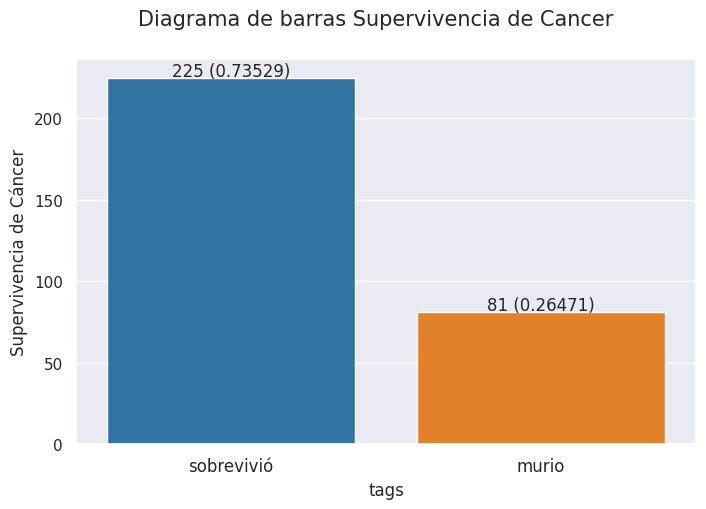

In [79]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='tags',
    ejey='Supervivencia de Cáncer',
    title=title_data,
    p=True)

Hay un serio desbalance en el conjunto de datos del 74% registros son para los pacientes que vivieron y 26% son los pacientes que murireron.


In [80]:
y = np.where(y==1, 0, 1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=12354,
    shuffle=True,
    stratify=y
)

- Como las categorías se encuentran desbalanceadas, se procede a realizar una partición estratificada.

# **Model**
---

## **Model Base**
---

In [82]:
def model_base():
  model = Sequential()
  model.add(Dense(10, input_dim=3, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [83]:
utils_keras.set_random_seed(12354)

In [84]:
model = model_base()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=5,
    verbose=0)

In [102]:
data.shape[0]/5

61.2

61.2 lotes con 5 muestras

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                40        
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Curvas de aprendizaje de optimización model base**
---

In [86]:
def optimization_learning_curves(
    history:dict,
    metrica:str,
    title:str='',
    X_size:int=8,
    y_size:int=4,
    font_size:int=15,
    X_label:str='Epoch',
    y_label:str='Loss'
)->None:
  """ Grafica curvas de aprendizaje """
  fig, ax = plt.subplots(figsize=(X_size, y_size))
  fig.suptitle(title, fontsize=font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(X_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper right', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()


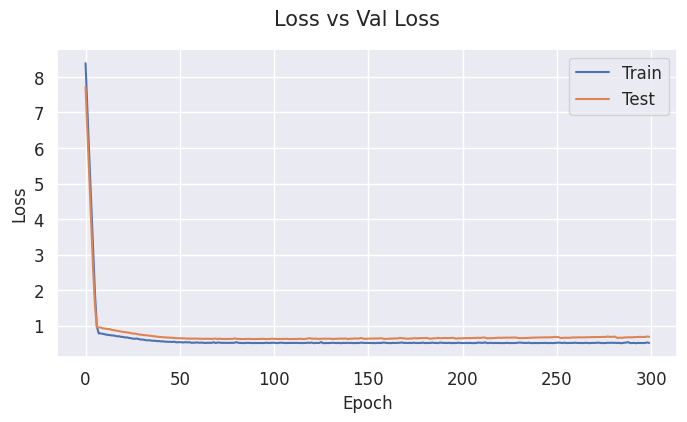

In [87]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 25 epocas, con una brecha que indica un sobreajuste. Este modelo sufre de variabilidad.

# **Prediction**
---

In [88]:
y_pred = (model.predict(X_test)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

5/5 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [89]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5, **kwards)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  v = list(kwards.values())
  k = list(kwards.keys())
  if ax.get_xticklabels()[0].get_text() == v[0]:
    ax.xaxis.set_ticklabels([k[0], k[1]])
    ax.yaxis.set_ticklabels([k[0], k[1]])
  else:
    ax.xaxis.set_ticklabels([k[1], k[0]])
    ax.yaxis.set_ticklabels([k[1], k[0]])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

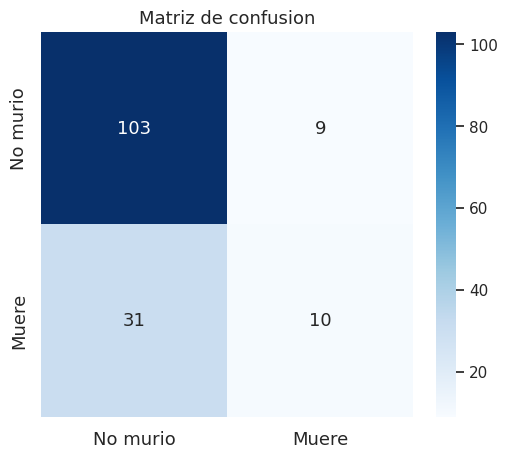

In [90]:
matrix = consufion_matrix(y_test, y_pred, **{'Muere':1, 'No murio':0})

- A partir de la matriz, el modelo tiene problemas para  detectar pacientes con posibilidades de morir en 5 años, ya que hay pocos verdaderos positivos.

In [92]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [93]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test, y_pred, matrix)

Accuracy  :   0.739
Kappa     :   0.197
predicción enfermos
Precision:   0.526
Recall    :   0.244
Specificity:   0.920
F1-score   :   0.333


- La sensibilidad es pesima, el conjunto de datos es muy pequeño el modelo no es el indicado, cabe resaltar que no se ha tratado la red, ya que la idea es experimentar con datos.

In [94]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

5/5 [==============================] - 0s 5ms/step


In [95]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

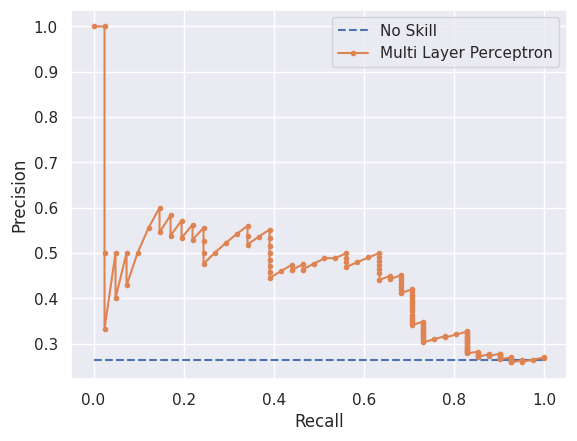

In [96]:
auc_score = precision_recall(y, pos_prob, y_test)

In [97]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.448


- Acorde al area bajo la curva entre la precisión y la sensibilidad es pesimo no superando el modelo **sin habilidad**
- Es posible que con más datos y una estructura más amplia el modelo pueda mejorar su capacidad de predicción para detectar pacientes con diabetes.
- No se ha estandarizado los datos, puede que tambien influya .

# **Cross Validation**
---

In [100]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=12354)

cv_score_loss_train, cv_score_loss_test = [], []

In [103]:
for train, test in kfold.split(X, y):
  model = model_base()
  model.fit(
      X[train],
      y[train],
      validation_data=(X[test], y[test]),
      epochs=300,
      batch_size=5,
      verbose=0)
  loss_train = model.evaluate(X[train], y[train], verbose=0)
  loss_test = model.evaluate(X[test], y[test], verbose=0)
  cv_score_loss_train.append(loss_train)
  cv_score_loss_test.append(loss_test)
  print('======================================================================')
  print('loss: %.3f val loss test: %.3f' % (loss_train * 100, loss_test * 100))

loss: 51.602 val loss test: 56.787
loss: 56.001 val loss test: 57.111
loss: 54.270 val loss test: 55.820
loss: 50.682 val loss test: 51.675
loss: 54.847 val loss test: 55.511
loss: 53.679 val loss test: 61.453
loss: 51.767 val loss test: 70.832
loss: 54.296 val loss test: 53.498
loss: 52.346 val loss test: 48.175
loss: 56.294 val loss test: 62.630


- Los valores de pérdida de entrenamiento y validación tienden a converger, pese a que el valor no  es bajo.
- El mmodelo pese a que no es el mejor para el problema que enfrenta, no se ve afectado por la varianza, aunque puede estar sesgado por la falta de datos.

In [104]:
print('============================== 10 Pliegues ==============================')
print('============================== Loss Train ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_train)*100, np.std(cv_score_loss_train)*100))
print('============================== Loss Test ==============================')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score_loss_test)*100, np.std(cv_score_loss_test)*100))

============================== 10 Pliegues ==============================
============================== Loss Train ==============================
53.58% (+/- 1.82%)
============================== Loss Test ==============================
57.35% (+/- 6.03%)


- La dispersión como la medida de la perdida tanto en entrenamiento, como en validación no se ven afectado por ruido estadistico es demasiado bajo, es confiable, pese a que la perdida tiene un valor que si bien no es alto, tampoco es bajo.

- `El modelo bajo la metrica de optimización y rendimiento seleccionadas, no se considera un modelo excelente para detectar el cancer de corazon, es necesario mirar que otras tecnia se pueden aplicar.`



# **Wrapper**
---

In [137]:
def model_optimizer(
    optimizer = 'rmsprop',
    init = 'glorot_uniform'
):
  model = Sequential()
  model.add(Dense(10, input_dim=3, activation='relu', kernel_initializer=init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
  model.compile(loss='binary_crossentropy', optimizer=optimizer)
  return model

In [106]:
model = KerasClassifier(
    build_fn=model_optimizer,
    epochs=300,
    batch_size = 5,
    verbose = 0)

In [107]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

- Los resultados no parecen ser tan alejados los unos de los otros, el modelo tiende a converger, poco ruido, pero no es el más indicado para la detección de cancer o falta más datos.

In [108]:
result.mean()*100, result.std()*100

(73.88172043010752, 4.907857178861532)

- La media es confiable, ya que la **dispersión no es tán prolongada**.


# **Optimización de hiperparametros**
---

In [139]:
model_optimizer = KerasClassifier(build_fn = model_optimizer, verbose = 0)

In [140]:
model_optimizer

KerasClassifier(
	model=None
	build_fn=<function model_optimizer at 0x7c0af05ef0a0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [141]:
params={
'batch_size':[5, 10, 15],
'epochs':[100, 150, 200],
'optimizer':['adam','rmsprop'],
'model__init':['glorot_uniform', 'normal', 'uniform', 'he_normal']
}

In [142]:
grid = GridSearchCV(
    estimator=model_optimizer,
    param_grid=params,
    refit = True,
    return_train_score=True, cv = 3)

In [144]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function model_optimizer at 0x7c0af05ef0a0>, verbose=0),
             param_grid={'batch_size': [5, 10, 15], 'epochs': [100, 150, 200],
                         'model__init': ['glorot_uniform', 'normal', 'uniform',
                                         'he_normal'],
                         'optimizer': ['adam', 'rmsprop']},
             return_train_score=True)

In [145]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.790850 usando {'batch_size': 5, 'epochs': 150, 'model__init': 'uniform', 'optimizer': 'rmsprop'}


In [146]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.764706 (0.000000) con {'batch_size': 5, 'epochs': 100, 'model__init': 'glorot_uniform', 'optimizer': 'adam'}
0.745098 (0.000000) con {'batch_size': 5, 'epochs': 100, 'model__init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.764706 (0.016010) con {'batch_size': 5, 'epochs': 100, 'model__init': 'normal', 'optimizer': 'adam'}
0.764706 (0.016010) con {'batch_size': 5, 'epochs': 100, 'model__init': 'normal', 'optimizer': 'rmsprop'}
0.771242 (0.009243) con {'batch_size': 5, 'epochs': 100, 'model__init': 'uniform', 'optimizer': 'adam'}
0.764706 (0.016010) con {'batch_size': 5, 'epochs': 100, 'model__init': 'uniform', 'optimizer': 'rmsprop'}
0.745098 (0.016010) con {'batch_size': 5, 'epochs': 100, 'model__init': 'he_normal', 'optimizer': 'adam'}
0.705882 (0.032019) con {'batch_size': 5, 'epochs': 100, 'model__init': 'he_normal', 'optimizer': 'rmsprop'}
0.777778 (0.033327) con {'batch_size': 5, 'epochs': 150, 'model__init': 'glorot_uniform', 'optimizer': 'adam'}
0.764706 (0.042358) con {'bat

In [147]:
model_final = grid.best_estimator_
model_final.get_params()

{'model': None,
 'build_fn': <function __main__.model_optimizer(optimizer='rmsprop', init='glorot_uniform')>,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': 5,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 150,
 'model__init': 'uniform',
 'class_weight': None}

#**Prediction**
---

In [148]:
y_pred = model_final.predict(X_test)

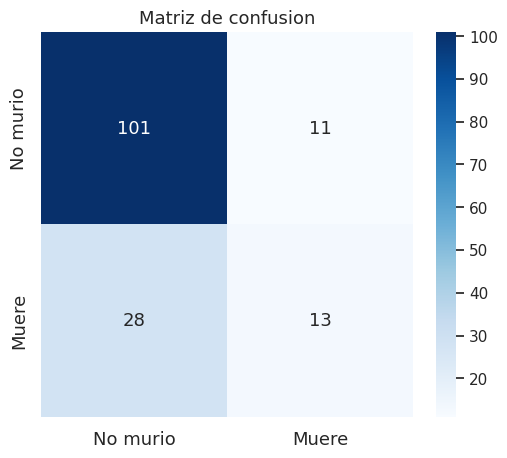

In [149]:
matrix = consufion_matrix(y_test, y_pred, **{'Muere':1, 'No murio':0})

In [150]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test, y_pred, matrix)

Accuracy  :   0.745
Kappa     :   0.252
predicción enfermos
Precision:   0.542
Recall    :   0.317
Specificity:   0.902
F1-score   :   0.400


- El modelo optimizado tiene una mejora casi imperceptible en la sensibilidad para la detección de casos con cancer, aunque la metrica no tiene un rendimiento alto para un caso tán critico como la detección de una enfermedad, ademas sigue teniendo un porcentaje de error tipo 2, demasiados falsos negativos.

In [151]:
pos_prob = model_final.predict_proba(X_test)

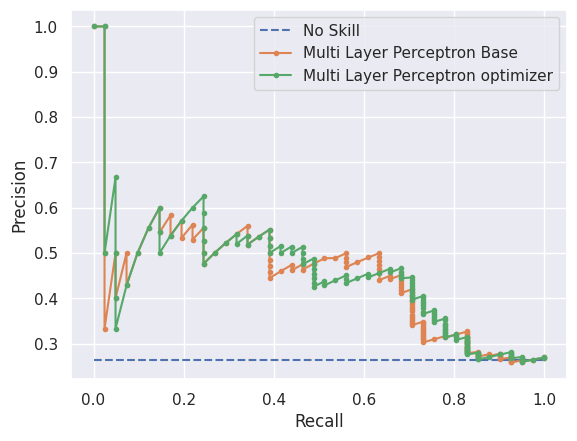

In [152]:
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron Base')
auc_score_normal = metrics.auc(recall, precision)
precision, recall, _ = metrics.precision_recall_curve(y_test, pos_prob[:,1])
plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron optimizer')
auc_score_optimizer = metrics.auc(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [153]:
print('Multi Layer Perceptron Normal PR AUC: %.3f' % auc_score_normal)
print('Multi Layer Perceptron Optimizer PR AUC: %.3f' % auc_score_optimizer)

Multi Layer Perceptron Normal PR AUC: 0.448
Multi Layer Perceptron Optimizer PR AUC: 0.454


- El modelo `optimizado` no tiene un rendimiento deseado, incluso el modelo `base` lo supera, ya que no logra tener una compensasión ideal entre la precisión y el recall. La causa pueden ser muchas, más falta de datos, una estructura ineficiente, puede que las redes neuronales no sean un modelo indicado, más experimentos en la optimización de parametros, entre otros.

